# Load Imporatant Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import uniform, normal
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import datetime

# Sampling function from GP with mixed Kernels

In [2]:
class CNPRegressionDescription:
    """ Constructor Class to store the context and target data points
    """
    def __init__(self, query, target_y):
        self.query = query
        self.target_y = target_y


class GPCurvesReader(object):
    """ Class to generate curves using a Gaussian Process(GP).
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        l1_scale=[0.4, 0.6],
        sigma_scale=[0.8, 1.2],
        testing=False,
    ):
        """Creating a dataset of functions sampled from the GP.

        Args:
          batch_size: No. of functions to be sampled.
          max_num_context: Max. no. of training points.
          x_size: Dimension of input vector.
          y_size: Dimension of output vector.
          l1_scale: Length scale of kernel.
          sigma_scale: Variance scale.
          testing: Boolean to check training or testing phase.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Function to evaluate least square Gaussian kernel.

        Args:
          xdata: input vector
          l1: length scale of kernel
          sigma_f: Variance scale
          sigma_noise: Noise to make Covariance matrix positive definite.

        Returns:
          The kernel output
        """
        num_total_points = xdata.shape[1] # Total no. of input points

        x1 = xdata.unsqueeze(dim=1) # Reshaping the input vector to a 4d matrix
        x2 = xdata.unsqueeze(dim=2) # Reshaping the input vector to a 4d matrix

        # Difference of x1 and x2 of shape = [B, num_total_points, num_total_points, x_size]
        diff = x1 - x2

        # Norm of the difference matrix of shape = [B, y_size, num_total_points, num_total_points]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :]) ** 2
        norm = norm.sum(dim=-1)

        # Kernel output of shape = [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f ** 2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Addition of noise to make the kernel positive definite
        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Function to generate the individual functions sampled from the GP

        Returns:
          A `CNPRegressionDescription` object.
        """

        num_context = 5 # 5 context points

        # Choose the random point
        partition = torch.rand(1).item() * 4 - 2

        # In case of testing, creating a set of evenly distributed num_target points between [-2,2] to plot the function.
        if self._testing:
            num_target = 401
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target)
            partition_idx = torch.searchsorted(x_values, partition, right=True) - 1
            num_partition_1 = partition_idx
            num_partition_2 = num_total_points - num_partition_1
            x_val_1, x_val_2 = x_values[:partition_idx], x_values[partition_idx:]
            x_val_1, x_val_2 = x_val_1.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1), x_val_2.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1)

        # In case of training, creating random no. of target points and a set of randomly distributed num_total_points points between [-2,2]
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,)).item()
            num_total_points = num_context + num_target
            num_partition_1 = int(max((num_total_points * (partition + 2)) // 4, 1))
            num_partition_2 = num_total_points - num_partition_1
            x_val_1 = torch.rand((self._batch_size, num_partition_1, self._x_size)) * (partition + 2) - 2
            x_val_2 = torch.rand((self._batch_size, num_partition_2, self._x_size)) * (2 - partition) + partition

        # Set kernel parameters
        l1, l2 = torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale[0], torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale[1]
        sigma_f1, sigma_f2 = torch.ones(self._batch_size, self._y_size) * self._sigma_scale[0], torch.ones(self._batch_size, self._y_size) * self._sigma_scale[1]

        # Evaluation of the kernel
        kernel1, kernel2 = self._gaussian_kernel(x_val_1, l1, sigma_f1), self._gaussian_kernel(x_val_2, l2, sigma_f2)

        # Cholesky decomposition of the kernel matrix
        cholesky1 = torch.cholesky(kernel1.type(torch.DoubleTensor)).type(
            torch.FloatTensor
        )
        cholesky2 = torch.cholesky(kernel2.type(torch.DoubleTensor)).type(
            torch.FloatTensor
        )

        # Evaluation of y_values
        y_val_1 = torch.matmul(
            cholesky1, torch.randn(self._batch_size, self._y_size, num_partition_1, 1)
        )
        y_val_2 = torch.matmul(
            cholesky2, torch.randn(self._batch_size, self._y_size, num_partition_2, 1)
        )

        # Reordering of the components of y_values
        y_val_1 = y_val_1.squeeze(3).permute([0, 2, 1])
        y_val_2 = y_val_2.squeeze(3).permute([0, 2, 1])

        # Concatenate the x-values and y-values into a single tensor
        x_values = torch.cat((x_val_1, x_val_2), dim=1)
        y_values = torch.cat((y_val_1, y_val_2), dim=1)

        # Selection of target and context points
        if self._testing:
            target_x = x_values
            target_y = y_values

            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y)

# Encoder Class

In [3]:
class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        """ Constructor class of the encoder
        """
        super(DeterministicEncoder, self).__init__()
        self.linears = [nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes) - 1)]
        self.linears = nn.ModuleList(self.linears)

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation

        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1

        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1) # Concatenating x and y labels
        batch_size, set_size, _ = encoder_input.shape # Storing the batch_size and set_size from the encoder input
        x = encoder_input.view(batch_size * set_size, -1)

        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        # Mean of x stored as representation vector
        representation = x.view(batch_size, set_size, -1).mean(dim=1)

        return representation

# Decoder Class

In [4]:
class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        """ Constructor class of Decoder
        """
        super(DeterministicDecoder, self).__init__()
        self.linears = [nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes) - 1)]
        self.linears = nn.ModuleList(self.linears)

    def forward(self, representation, target_x):
        """
        Function to return distribution of x

        Args:
            representation: output from encoder class
            target_x: Prediction x_values
        """
        batch_size, set_size, _ = target_x.shape # Storing the batch_size and set_size from the target x_values
        representation = representation.unsqueeze(1).repeat([1, set_size, 1]) # Reshaping the dimensions of representation tensor
        decoder_input = torch.cat((representation, target_x), dim=-1) # Concatenating the representation and target_x tensors
        x = decoder_input.view(batch_size * set_size, -1)

        # Applying ReLu activation function
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        decoder_output = x.view(batch_size, set_size, -1)

        mean, log_sigma = torch.split(decoder_output, 1, dim=-1) # Mean of the decoder output
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma) # # Std. Dev. of the decoder output

        distribution = torch.distributions.normal.Normal(loc=mean, scale=sigma) # Prob. dist. of the Gaussian with mean and sigma parameters

        return distribution, mean, sigma

# Conditional Neural Process Model

In [5]:
class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        """ Constructor class of the model
        """
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        """ Function to encode and decode the training and testing data points
        """
        (context_x, context_y), target_x = query # Reading the context and target values
        representation = self._encoder(context_x, context_y) # Calling the encoder function for the query
        distribution, mean, sigma = self._decoder(representation, target_x) # Storing the distribution of the query

        log_p = None if target_y is None else distribution.log_prob(target_y) # Log of probability distribution
        return log_p, mean, sigma

# Plot Functions

In [6]:
def plot_CNP_prediction(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the CNP predicted mean and variance along with context points

    Args:
      target_x: Array of x values for target points.
      target_y: Array of y values for target points.
      context_x: Array of x values for context points.
      context_y: Array of y values for context points.
      pred_y: Predicted y values for target points.
      var: Variance of predicted y values.
    """
    # Plot predictions and variance
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0], pred_y[0], "b", label="Predicted Mean", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", label="Ground Truth", linewidth=2)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor="#65c9f7",
        label="Predicted Variance",
        interpolate=True,
    )

    # Plot context points
    plt.scatter(context_x[0], context_y[0], color='black', label="Context Points", s=100)

    # Customize plot appearance
    plt.xlabel("X", fontsize=14)
    plt.ylabel("Y", fontsize=14)
    plt.title("CNP Model", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# Conditional Neural Process Model for Function Regression

In [7]:
# Important Parameters for Training Routine
TRAINING_ITERATIONS = 150000
PLOT_AFTER = 10000
MAX_CONTEXT_POINTS = 10

In [8]:
# Set the seed for reproducibility
torch.manual_seed(0)
# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

In [9]:
# Dimensions for encoder and decoder inputs
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]

# Modelling and optimizing the parameters using Adam optimizer
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13416\2382381123.py:114: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  cholesky1 = torch.cholesky(kernel1.type(torch.DoubleTensor)).type(


2024-04-23 22:03:38, Iteration: 0, test loss: 1.4487065076828003


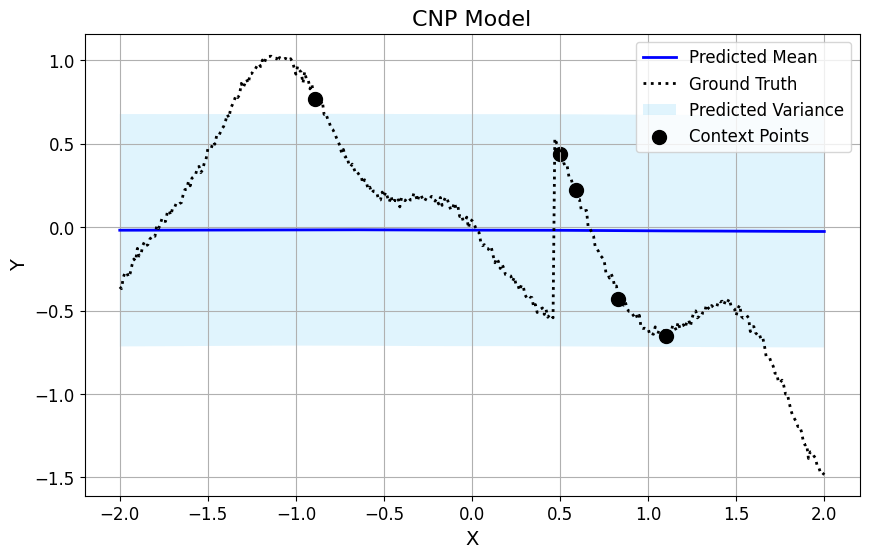

2024-04-23 22:05:39, Iteration: 10000, test loss: 0.9824487566947937


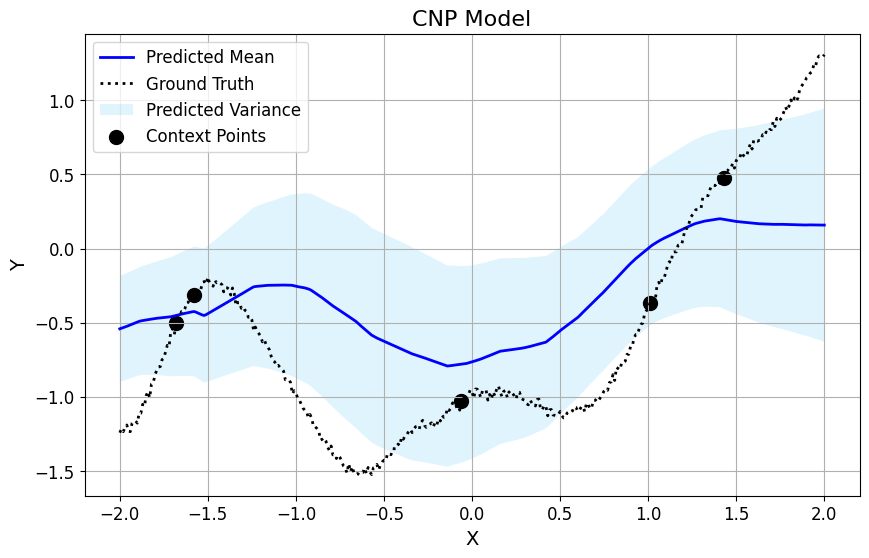

2024-04-23 22:07:57, Iteration: 20000, test loss: 0.8314988017082214


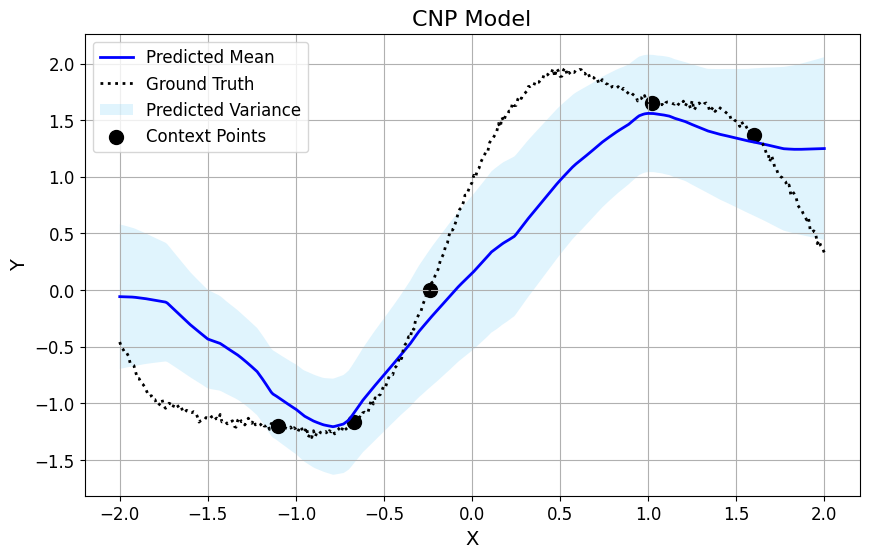

2024-04-23 22:10:15, Iteration: 30000, test loss: 0.7679848074913025


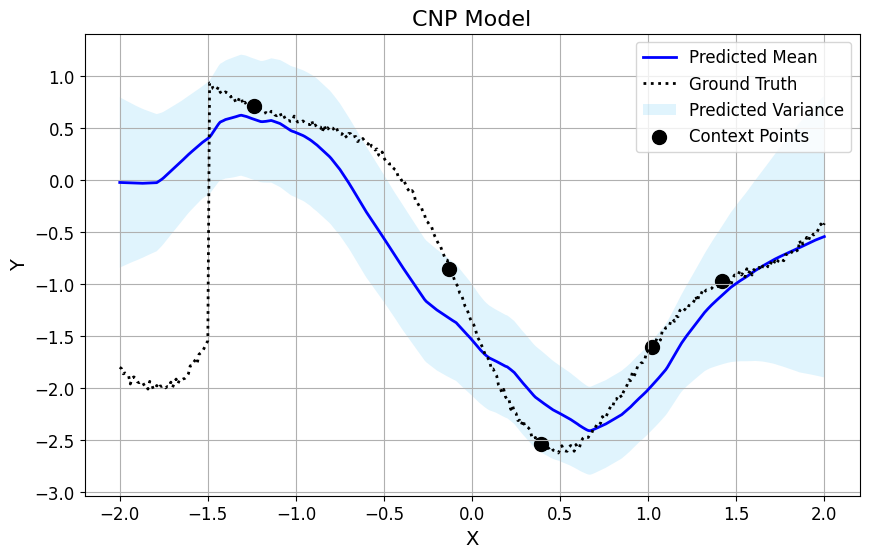

2024-04-23 22:12:44, Iteration: 40000, test loss: 0.8410366773605347


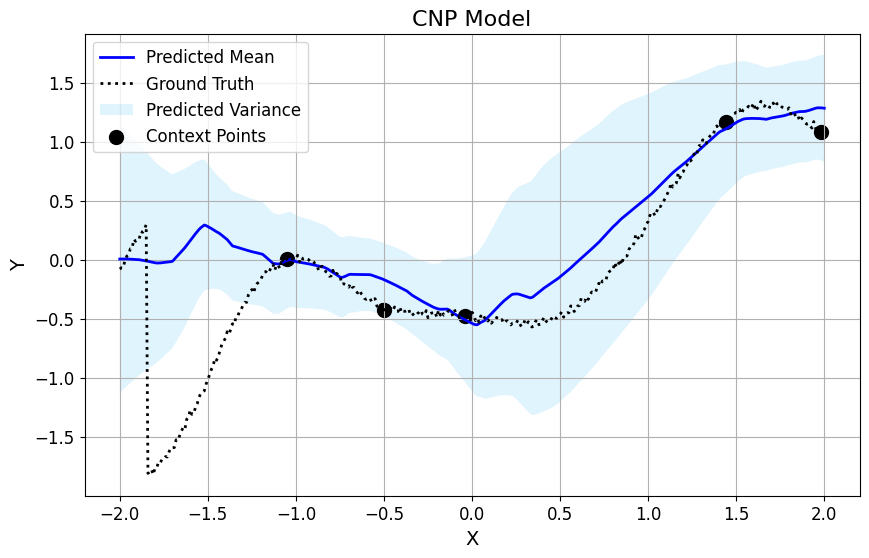

2024-04-23 22:15:13, Iteration: 50000, test loss: 1.13079035282135


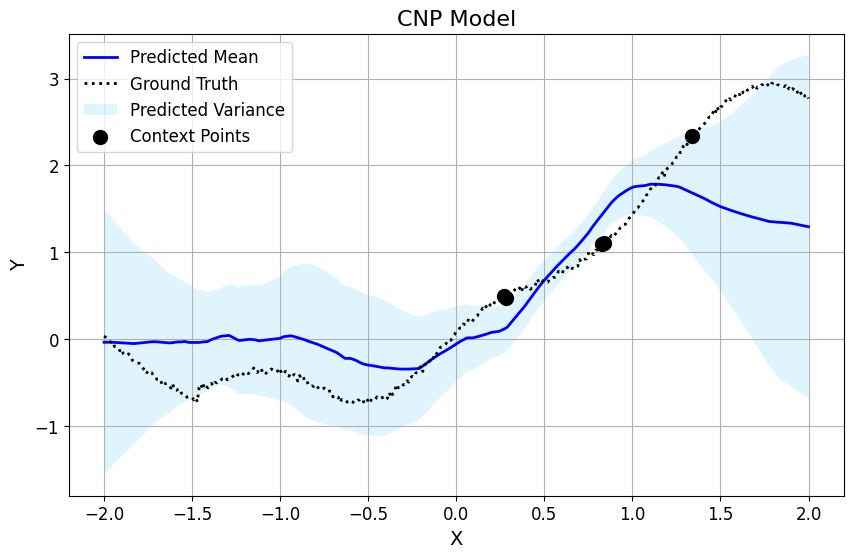

2024-04-23 22:17:38, Iteration: 60000, test loss: 1.0292487144470215


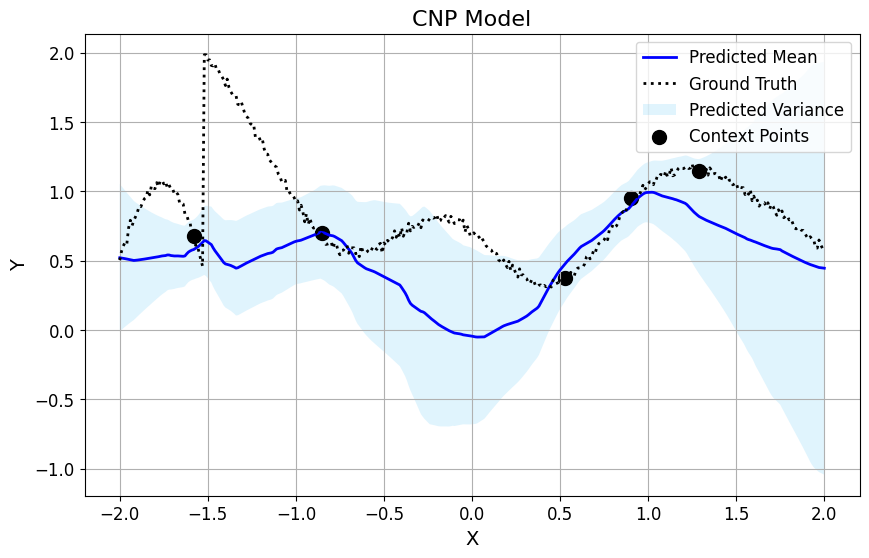

2024-04-23 22:20:05, Iteration: 70000, test loss: 0.8584465384483337


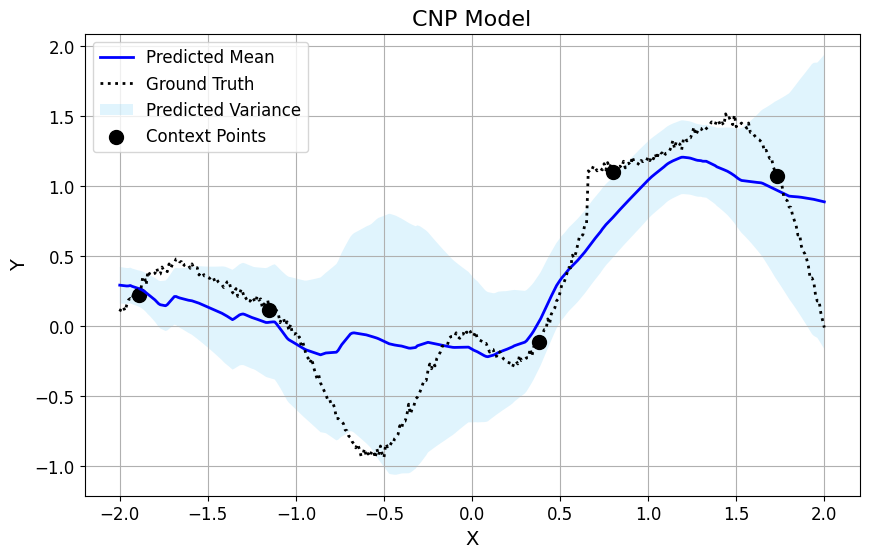

2024-04-23 22:22:30, Iteration: 80000, test loss: 0.8179611563682556


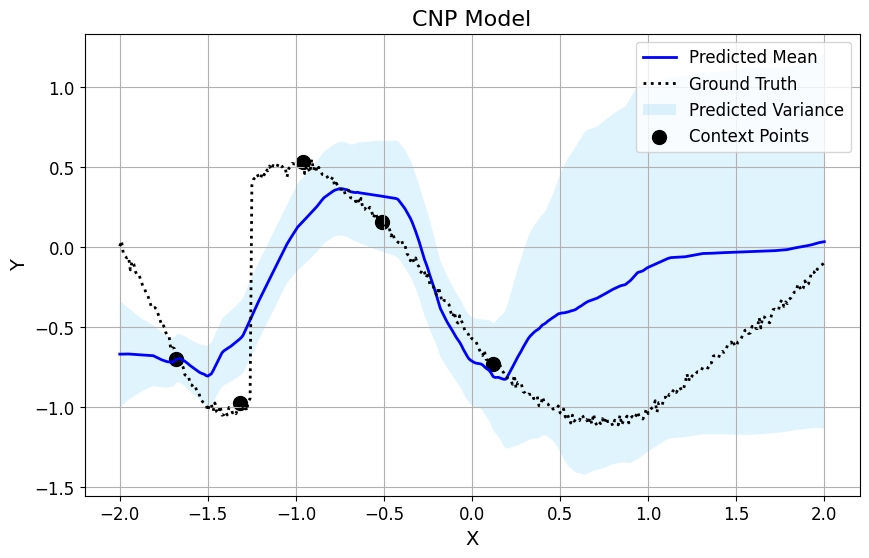

2024-04-23 22:24:55, Iteration: 90000, test loss: 0.9834336042404175


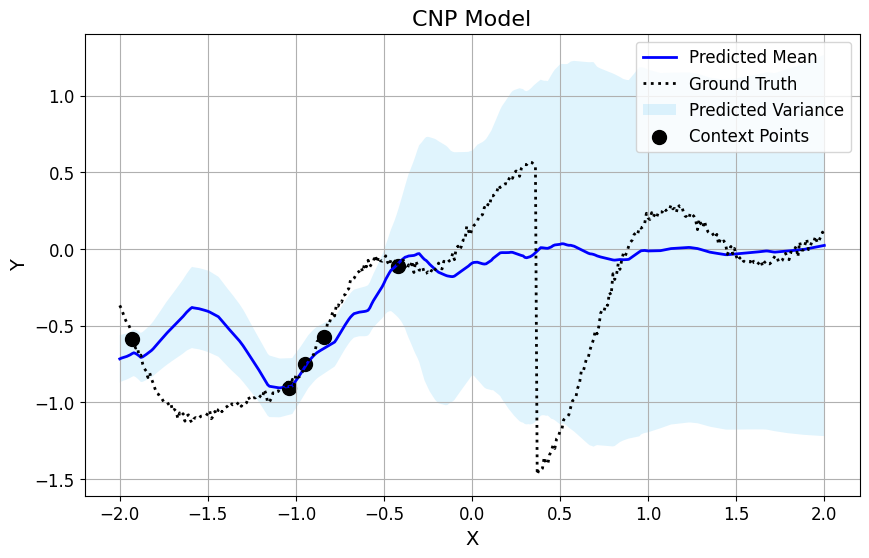

2024-04-23 22:27:28, Iteration: 100000, test loss: 0.8261224031448364


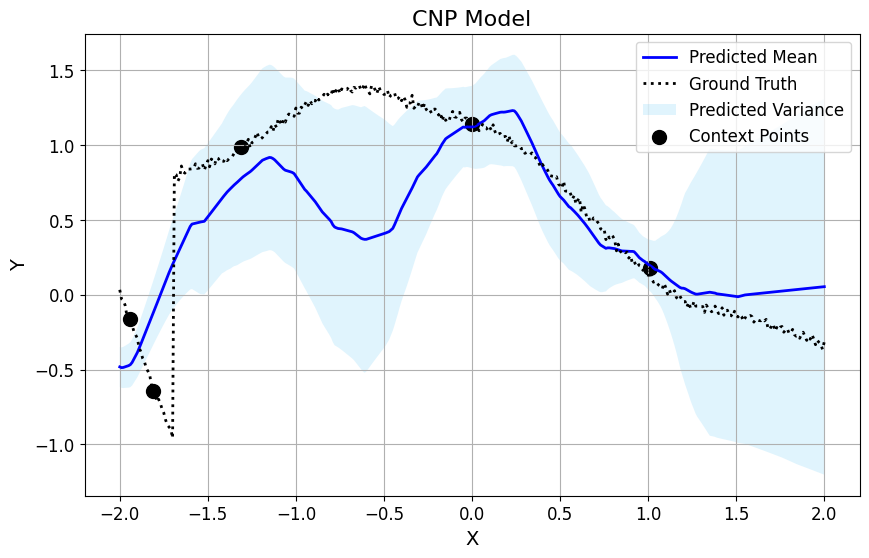

2024-04-23 22:30:05, Iteration: 110000, test loss: 0.7058249115943909


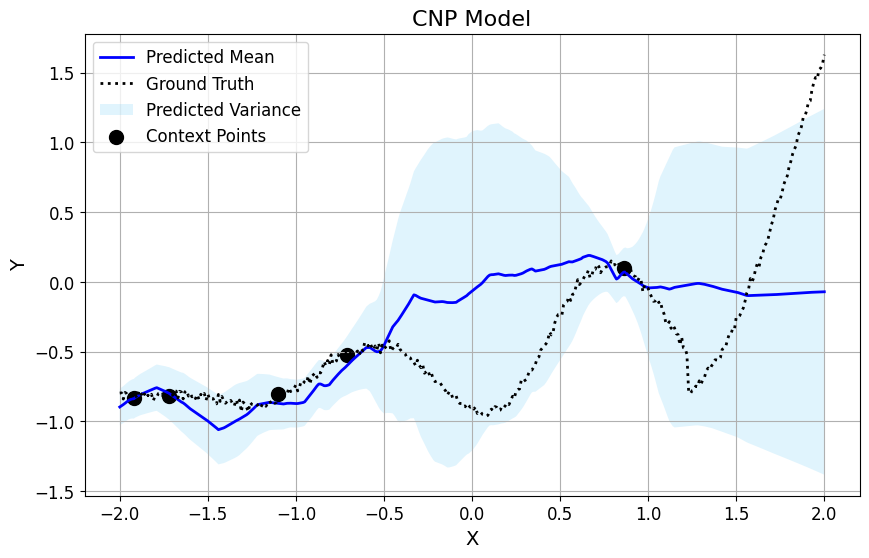

2024-04-23 22:32:16, Iteration: 120000, test loss: 0.6525882482528687


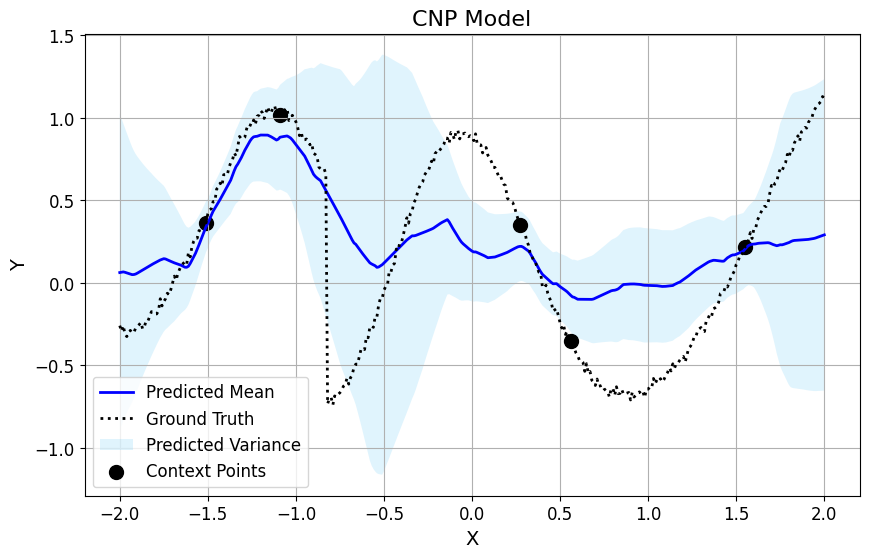

2024-04-23 22:34:12, Iteration: 130000, test loss: 0.7026566863059998


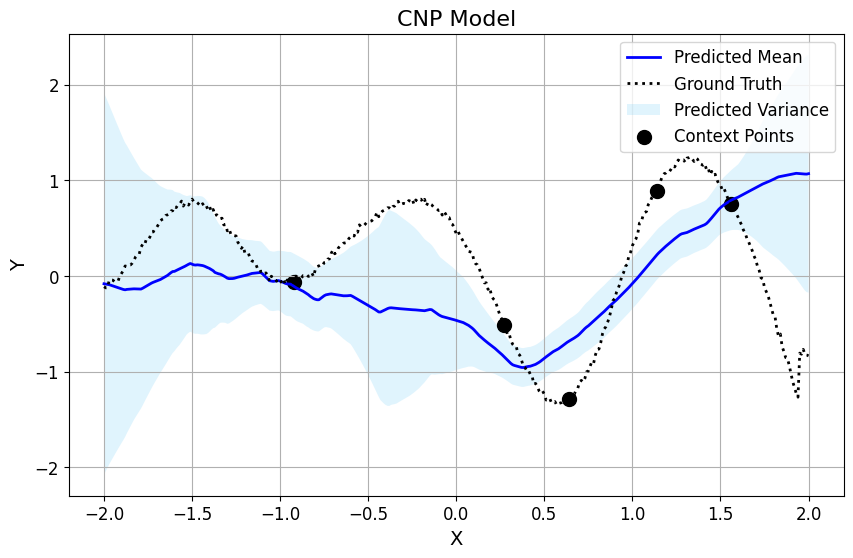

2024-04-23 22:36:17, Iteration: 140000, test loss: 0.8278698921203613


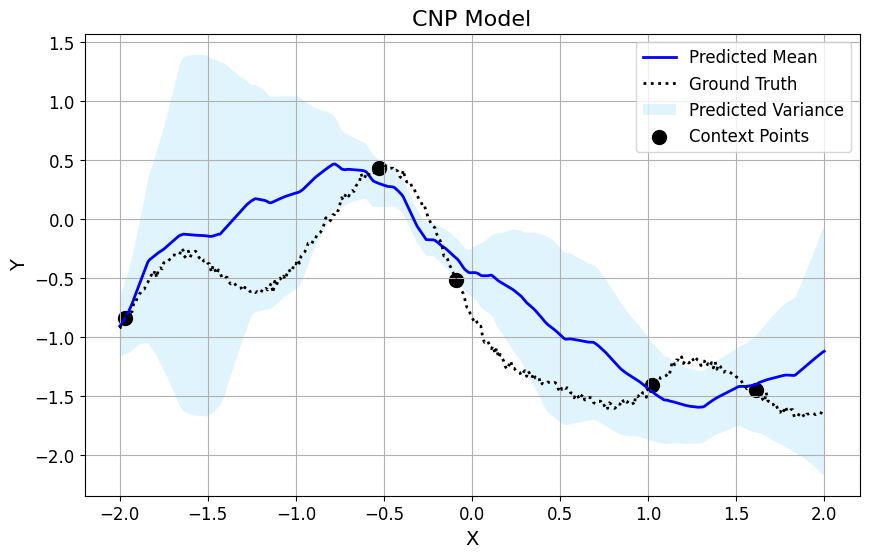

In [10]:
for it in range(TRAINING_ITERATIONS):
    data_train = dataset_train.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves()
        test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()

        print("{}, Iteration: {}, test loss: {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss))
        (context_x, context_y), target_x = data_test.query

        plot_CNP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y.detach().numpy(), var.detach().numpy())

2024-04-23 22:38:27, Iteration: 150000, test loss: 0.9174573421478271


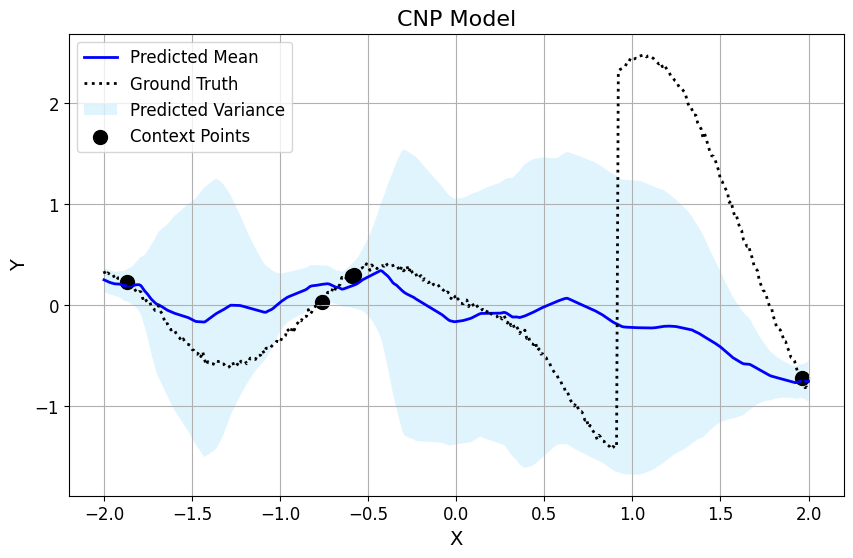

In [11]:
data_test = dataset_test.generate_curves()
test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
test_loss = -test_log_prob.mean()

print("{}, Iteration: {}, test loss: {}".format(
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), TRAINING_ITERATIONS, test_loss)
)

(context_x, context_y), target_x = data_test.query
plot_CNP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y.detach().numpy(), var.detach().numpy())